# FINAL PROJECT: Regression

- **Main objective** : I chose to work on the Insurance to model to predict the charge of insurance on different people   link:https://www.kaggle.com/datasets/mirichoi0218/insurance
- **Description of the dataset**: This dataset was inspired by the book Machine Learning with R by Brett Lantz.Today we will explore a data set dedicated to the cost of treatment of different patients. The cost of treatment depends on many factors The data contains medical information and costs billed by health insurance companies. It contains 1338 rows of data and 8 columns
- **Summary of the attributes** :age:Integer , sex:male/female , bmi:float , children:Integer , Smoker:yes/no , region:southwest/southeast/northwest/northeast, Target:charges:float

## Data overview

In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv('./insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


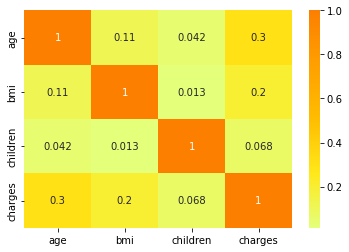

In [7]:
import seaborn as sns
# correlation plot
corr = data.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True);

## Data exploration / feature engeneering

### Normal distribution of the target

Before Starting anything, we need to make sure that the target has a normal distribution

<AxesSubplot:>

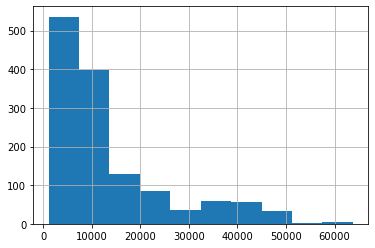

In [8]:
data.charges.hist()

In [9]:
from scipy.stats.mstats import normaltest
normaltest(data.charges.values)

NormaltestResult(statistic=336.8851220567733, pvalue=7.019807901276197e-74)

the **p value <0.05** is really small the target is not normally distributed . We need to transform it

####  Log transformation

<AxesSubplot:>

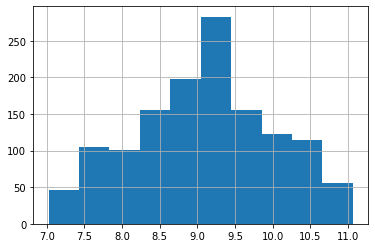

In [10]:
log_charges = np.log(data.charges)
log_charges.hist()

In [11]:
normaltest(log_charges)

NormaltestResult(statistic=52.71670509113935, pvalue=3.5703676381337117e-12)

#### Square root transformation

<AxesSubplot:>

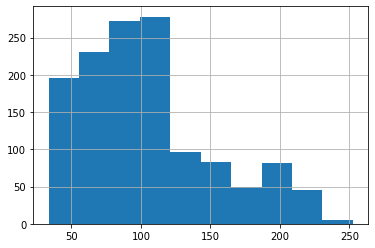

In [12]:
sqrt_charges = np.sqrt(data.charges)
sqrt_charges.hist()

In [13]:
normaltest(sqrt_charges)

NormaltestResult(statistic=112.4605295472106, pvalue=3.7975744156203163e-25)

#### Boxcox transformation

(array([ 64.,  97., 113., 164., 221., 278., 135., 104., 115.,  47.]),
 array([ 8.21807622,  8.81841614,  9.41875606, 10.01909598, 10.6194359 ,
        11.21977582, 11.82011575, 12.42045567, 13.02079559, 13.62113551,
        14.22147543]),
 <BarContainer object of 10 artists>)

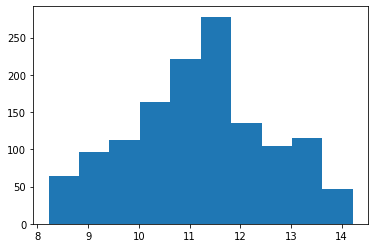

In [14]:
from scipy.stats import boxcox
import matplotlib.pyplot as plt
%matplotlib inline
bc_result = boxcox(data.charges)
boxcox_charges = bc_result[0]
lam = bc_result[1]
plt.hist(boxcox_charges)

In [15]:
normaltest(boxcox_charges)

NormaltestResult(statistic=54.4181017156977, pvalue=1.5249631686757666e-12)

#### Yeojohnson transformation

In [16]:
from scipy.stats import yeojohnson
yf_charges, lam = yeojohnson(data.charges)
normaltest(yf_charges)

NormaltestResult(statistic=54.44715332348858, pvalue=1.502971959411946e-12)

Out of all the different transformation, the best p value is the Log transformation one, it is still small, so we have too keep in mind in the following step that our target IS NOT NORMALLY DISTRIBUTED

In [17]:
# Replacing charges with log_charges
data1=data.copy()
data1.charges=log_charges
data1.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,9.734176
1,18,male,33.770,1,no,southeast,7.453302
2,28,male,33.000,3,no,southeast,8.400538
3,33,male,22.705,0,no,northwest,9.998092
4,32,male,28.880,0,no,northwest,8.260197


### One hot Encoding

We have 3 categorical features that need to be encoded, I chose one hot Encoding because it isn't ordinal and also erasing one of the columns to minimize the Variance Inflation Factor

In [18]:
mask=data1.dtypes==np.object
cat_cols=data1.columns[mask]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1960\3533536820.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=data1.dtypes==np.object


In [19]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
ohc = OneHotEncoder()
le = LabelEncoder()
num_ohc_cols = (data1[cat_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))

data1_ohc=data1.copy()
num_ohc_cols

region    4
sex       2
smoker    2
dtype: int64

In [20]:
for col in num_ohc_cols.index:
    # Integer encode the string categories
    dat = le.fit_transform(data1_ohc[col]).astype(np.int)
    
    # Remove the original column from the dataframe
    data1_ohc = data1_ohc.drop(col, axis=1)

    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=data1_ohc.index, 
                          columns=col_names)

    # Append the new data to the dataframe
    data1_ohc = pd.concat([data1_ohc, new_df], axis=1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1960\1342892857.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dat = le.fit_transform(data1_ohc[col]).astype(np.int)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1960\1342892857.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, chec

In [21]:
data1_ohc.head()   #The new encoded variable

,age,bmi,children,charges,region_0,region_1,region_2,region_3,sex_0,sex_1,smoker_0,smoker_1
0,19,27.900,0,9.734176,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,18,33.770,1,7.453302,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,28,33.000,3,8.400538,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,33,22.705,0,9.998092,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,32,28.880,0,8.260197,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [22]:
data1_ohc=data1_ohc.drop(axis=1,columns=['sex_1','smoker_1'])
data1_ohc.head()

,age,bmi,children,charges,region_0,region_1,region_2,region_3,sex_0,smoker_0
0,19,27.900,0,9.734176,0.0,0.0,0.0,1.0,1.0,0.0
1,18,33.770,1,7.453302,0.0,0.0,1.0,0.0,0.0,1.0
2,28,33.000,3,8.400538,0.0,0.0,1.0,0.0,0.0,1.0
3,33,22.705,0,9.998092,0.0,1.0,0.0,0.0,0.0,1.0
4,32,28.880,0,8.260197,0.0,1.0,0.0,0.0,0.0,1.0


In [23]:
data1_ohc_std=data1_ohc.copy()

**I also scaled it just in case i needed it **

In [24]:
from sklearn.preprocessing import StandardScaler
std_scaler=StandardScaler()


data_scaled=std_scaler.fit_transform(data1_ohc[['age','bmi','children']].to_numpy())
data_scaled= pd.DataFrame(data_scaled, columns=['age','bmi','children'])
data_scaled=pd.concat([data_scaled,data1_ohc[['region_0','region_1','region_2','region_3','sex_0','smoker_0','charges']] ], axis=1)
data_scaled.head()  # the variable encoded and scaled

,age,bmi,children,region_0,region_1,region_2,region_3,sex_0,smoker_0,charges
0,-1.438764,-0.453320,-0.908614,0.0,0.0,0.0,1.0,1.0,0.0,9.734176
1,-1.509965,0.509621,-0.078767,0.0,0.0,1.0,0.0,0.0,1.0,7.453302
2,-0.797954,0.383307,1.580926,0.0,0.0,1.0,0.0,0.0,1.0,8.400538
3,-0.441948,-1.305531,-0.908614,0.0,1.0,0.0,0.0,0.0,1.0,9.998092
4,-0.513149,-0.292556,-0.908614,0.0,1.0,0.0,0.0,0.0,1.0,8.260197


## Cross validation
For all my model i chose to work with cross validation , using 10 folds

In [25]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

## 1- Basic linear regression 

In [26]:
s = StandardScaler()
lr = LinearRegression()
estimator = Pipeline([("scaler", s),
                      ("regression", lr)]) # Scaling doesn't work with linear regression
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
X=data1_ohc.drop(columns='charges',axis=1)
y=data1_ohc.charges
predictions = cross_val_predict(estimator, X, y, cv=kf)
print('Basic linear regression score :')
r2_score(y, predictions)

Basic linear regression score :


0.765001860557051

## 2- Scaling + Lasso regression
Finding the best alpha value for lasso regression

In [27]:
alphas = np.geomspace(1e-9, 1e0, num=20)
alphas
scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("lasso_regression", las)]) # Lasso must be scaled

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)
print(' Scaling + Lasso Regression scores with different alphas')
scores

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.255e+00, tolerance: 1.011e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.532e+00, tolerance: 1.019e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.546e+00, toler

 Scaling + Lasso Regression scores with different alphas


[0.7654011605061627,
 0.7654011605773992,
 0.765401160800197,
 0.7654011612616691,
 0.7654011612245605,
 0.7654011616075016,
 0.7654011655858531,
 0.7654011658843887,
 0.7654012107040318,
 0.7654013156445559,
 0.7654016389850766,
 0.7654016146928753,
 0.7653989755951209,
 0.7653768120653799,
 0.7651930985358065,
 0.7636193641765882,
 0.7545808662107318,
 0.7114057047882862,
 0.46378211097379896,
 -0.0010174314501429915]

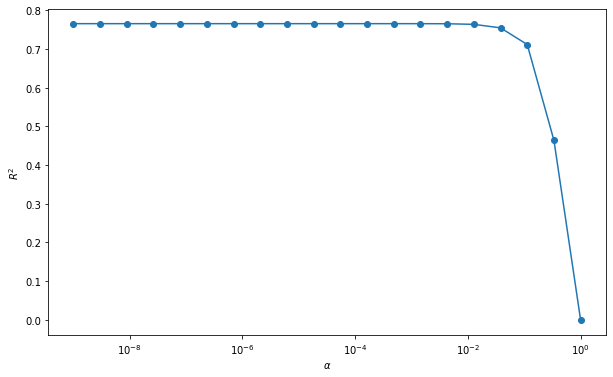

In [28]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

## 3- Polynomial effect on lasso

In [29]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree=3)
scores = []
alphas = np.geomspace(0.05, 5.0, 20)
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

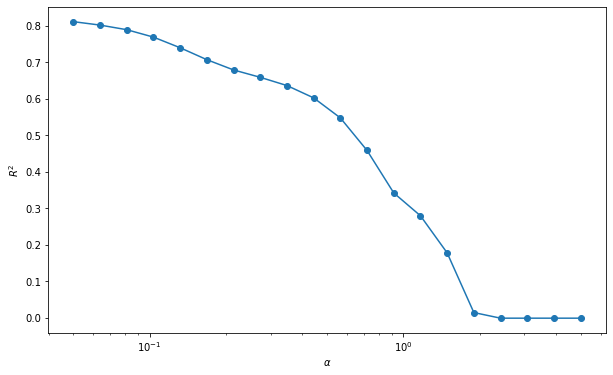

In [30]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [43]:
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=3)),
                    ("lasso_regression", Lasso(alpha=0.003))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.851031300373809

In [44]:
best_estimator.named_steps["lasso_regression"].coef_

array([ 0.00000000e+00,  3.20477128e-01,  0.00000000e+00,  1.03680346e-02,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        3.55586309e-03, -0.00000000e+00, -2.41025342e-02, -1.13790560e-02,
       -9.02040102e-02, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -2.85167206e-02,  1.73963608e-01, -8.56211263e-03,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.48104421e-02,
       -0.00000000e+00, -7.42588586e-03, -0.00000000e+00, -1.45994320e-02,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  5.73118038e-02,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  

In [45]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names(),
                 best_estimator.named_steps["lasso_regression"].coef_,
))
df_importances.sort_values(by=1)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1
219,x8^3,-0.183211
12,x0 x2,-0.090204
78,x0 x2 x8,-0.034966
17,x0 x7,-0.028517
10,x0^2,-0.024103
...,...,...
57,x0^2 x2,0.052886
33,x2 x8,0.057312
135,x1 x8^2,0.085028
18,x0 x8,0.173964


## 4- GridSearchCV

In [46]:
from sklearn.model_selection import GridSearchCV
# Same estimator as before
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])
params = {
    'polynomial_features__degree': [1, 2, 3 ,4],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3, 4],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [47]:
print('GridSearchCV Best params:')
grid.best_score_, grid.best_params_

GridSearchCV Best params:


(0.8323044479492534,
 {'polynomial_features__degree': 2,
  'ridge_regression__alpha': 11.481691038624568})

In [62]:
y_predict = grid.predict(X)

In [63]:
r2_score(y, y_predict)

0.8430317410018495

## Regularization regression

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.011e+02, tolerance: 1.130e-01
  model = cd_fast.enet_coordinate_descent(


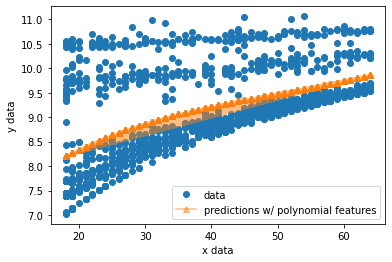

In [83]:
X_data=X[['age']]
# Create the features and fit the model
X_poly = pf.fit_transform(X_data)
lr = lr.fit(X_poly, y)
Y_pred = lr.predict(X_poly)

# The ridge regression model
rr = Ridge(alpha=0.001)
rr = rr.fit(X_poly, y)
Y_pred_rr = rr.predict(X_poly)

# The lasso regression model
lassor = Lasso(alpha=0.001)
lassor = lassor.fit(X_poly, y)
Y_pred_lr = lassor.predict(X_poly)

# Plot the result
plt.plot(X_data.values, y.values, marker='o', ls='', label='data', alpha=1)
plt.plot(X_data.values, Y_pred, marker='^', alpha=.5, label='predictions w/ polynomial features')
plt.legend()
ax = plt.gca()
ax.set(xlabel='x data', ylabel='y data');


## Best Regression
We tried different approaches for our Regression with variant scores . The best results we had were with polynomail+ Lasso regression with 0.85 of accuracy , followed by Gridsearch cv 0.84 , Basic lasso with a max of 0.77 with the best params and finally basic Linear regression 0.77

## Next step
- Trying to make the distribution normal
- Looking at the correlation with categorical values(we only studied numerical)
- Feature Engeneering: adding more features related to the health of patients, and seeing if the region really matters in our analysis